In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from astropy.io import fits
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack, join
from astropy.modeling import models
from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import NDUncertainty

from astroquery.simbad import Simbad
from astroquery.nist import Nist
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.mast import Observations

%matplotlib inline

In [34]:
def redshift_correction(wavelengths_observed, z):
    '''
    Finds amount by which stellar emission is redshifted, and subtract this from stellar spectrum.
    Input:
    wavelengths_observed: observed wavelengths of spectrum (Angstroms)
    z: redshift of star
    
    Returns:
    wavelengths_emitted: emitted wavelengths of spectrum (Angstroms)
    '''
    
    wavelengths_emitted = wavelengths_observed / (1 + z)
    return wavelengths_emitted


def blackbody(wavelengths, Teff):
    '''
    Returns blackbody continuum for an object at Teff (K)
    Inputs:
    wavelengths [arr]: (Angstroms)
    Teff [scalar]: effective temperature (K)
    
    Returns:
    B [arr]: blackbody continuum for Teff (unitless)
    '''
    
    wav = wavelengths * aangstrom2meter * u.m
    Teff = Teff * u.K
    
    B = (2. * const.h * const.c**2) / (wav**5.) / ( np.exp( (const.h * const.c) / (wav * const.k_B * Teff) ) - 1. )
    
    return B / B.max()


def fitBB(wavelengths, Teff, a, b):
    '''
    Scale blackbody continuum emission.
    Input:
    wavelengths [arr]: spectrum wavelengths (Angstroms)
    Teff [scalar]: effective temperature of star (K)
    a, b: scaling factors to be optimized by curve_fit
    
    Returns:
    -- [arr]: blackbody continuum curve
    '''
    return a * blackbody(wavelengths, Teff) + b



##########################
## Define helper functions
##########################

aangstrom2meter = 10**-10
joules2ergs = 10**7

# Retrieve and clean data

In [30]:
table = Table.read('/Users/isabelkain/Desktop/GALEX/data/dataset.ecsv')

# ## Search by SWPID
# swpid = 'swp54543'
# subtable = table[table['obs_id']==swpid]
# starname = subtable['main_id'].value[0]

## Search by starname
starname = '* d Dra'
subtable = table[table['main_id']==starname] ## FIXME Table has double spaces in some parts, that's why it doesnt recognize
swpid = subtable['obs_id'].value[0]


print(starname, swpid)
subtable


* d Dra swp02670


main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5
* d Dra,Star,F8Ib-II,swp02670,278.1447958072,57.0458246723,278.143469,57.045216,278.1438441389,57.0455960482,43768.89097,43768.93263,3599.844,Ultraviolet Observations of A and F Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/02000/gif/swp02670.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp02670mxlo_vo.fits,279.045069,57.015674,183.0,183.0,17.1818,0.0436,12.7877,0.0031,256,17,0,3,486.72198,19.5186,27855.59961,80.6932,A,2020yCat.1350....0G,*|IR|UV,-12.32,0.17,-4.11e-05,6e-07,1.02,0.0583,0.068,-7.961,5.38,4.761,--,3.093,2.93,2.704,--,--,--,--,--,5.38,0.009,Vega,D,--,--,,--,--,--,,--,3.093,0.208,Vega,D,2.704,0.236,Vega,D,* d Dra,6239,1.5000,-0.160,--,--,18.00,--,0,D,F8Ib-II,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,1.020,4,0.0583,A,980.3920,pc,-56.0361,56.0361,paral


In [31]:
## Open FITS file

hdul = fits.open(f'/Users/isabelkain/Desktop/GALEX/data/{swpid}.fits')


## Collect exposure information from header

target = hdul[1].header['OBJECT']       # target name
spclass = hdul[1].header['SRCCLASS']    # Object Class 
camera = hdul[0].header['CAMERA']       # or hdul[1].header['INSTRUME']
dispersion = hdul[0].header['DISPERSN'] # LOW or HIGH
fluxcal = hdul[1].header['FLUX_CAL']    # should be ABSOLUTE
tstart = float(str(hdul[0].header['?JD-OBS']).split('=')[1].split('/')[0].strip())      # [d] MJD exposure start time 
exptime = hdul[1].header['EXPOSURE']    # [s] eff. exposure duration
snr = hdul[1].header['DER_SNR']         # Derived signal-to-noise ratio  


## Collect star information from dataset

z = table[table['main_id']==starname]['redshift'].value[0]
Teff = table[table['main_id']==starname]['Fe_H_Teff'].value[0]


## Read in wavelength, flux, and fluxerr data

wavelengths = redshift_correction(hdul[1].data['WAVE'][0], z)
rawflux = hdul[1].data['FLUX'][0] # raw because blackbody continuum will soon be subtracted
fluxerr = hdul[1].data['SIGMA'][0]

print(target)
print(spclass)
print(camera)
print(dispersion)
print(fluxcal)
print(tstart)
print(exptime)
print(snr)

HR 6978
F3-F9
SWP
LOW
ABSOLUTE
2443768.89097
3599.844
1.62


Text(0.5, 1.0, 'LOW-DISP SWP, SNR 1.62')

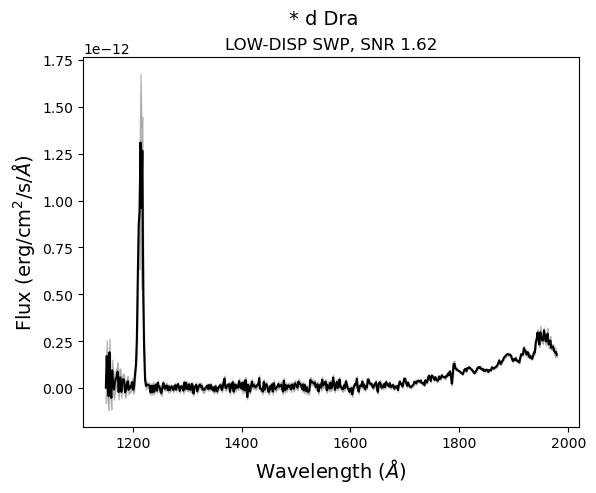

In [32]:
## Visualize spectrum

# fig, ax = plt.subplots(1,2, figsize=(10,5))
plt.tight_layout(rect=[0, 0.03, 1, 0.90])

plt.plot( wavelengths, rawflux, c='k')
plt.fill_between(wavelengths, rawflux + fluxerr, rawflux - fluxerr, alpha=0.5, color='gray')

# ax[1].plot( wavelengths, rawflux, c='k')
# ax[1].fill_between(wavelengths, rawflux + fluxerr, rawflux - fluxerr, alpha=0.5, color='gray')
# ax[1].set_ylim(-10**-14, 10**-13)

plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

plt.suptitle(f'{starname}', fontsize=14)
plt.title(f'{dispersion}-DISP {camera}, SNR {snr}')

# plt.ylim(-.2*10**-9, 10**-9)
# plt.yscale('log')

(-5e-14, 1e-13)

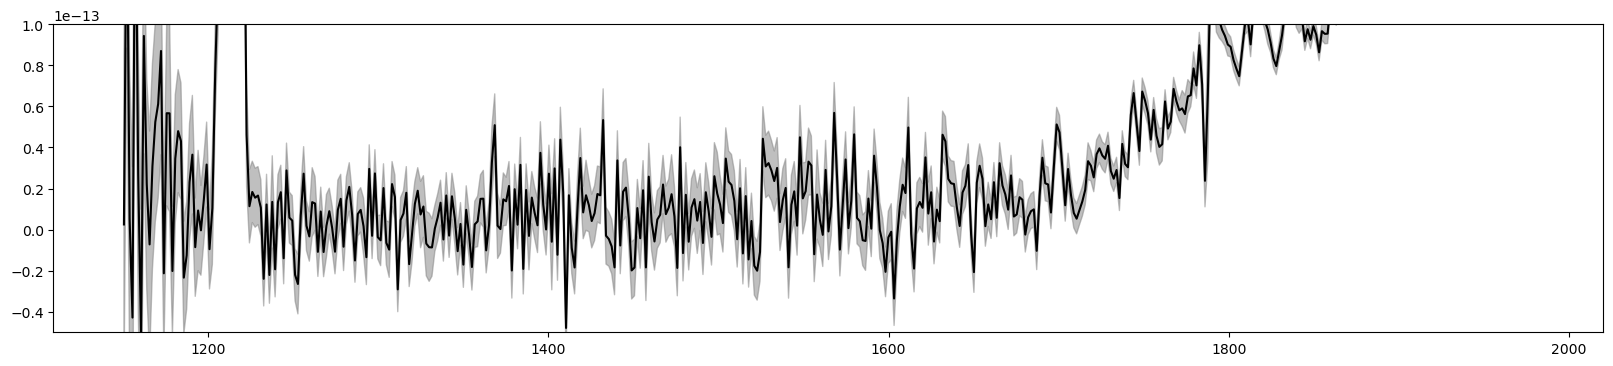

In [55]:
plt.figure(figsize=(20,4))
plt.plot( wavelengths, rawflux, c='k')
plt.fill_between(wavelengths, rawflux + fluxerr, rawflux - fluxerr, alpha=0.5, color='gray')

plt.ylim(-.05*10**-12, .1*10**-12)

In [56]:
Teff

6239

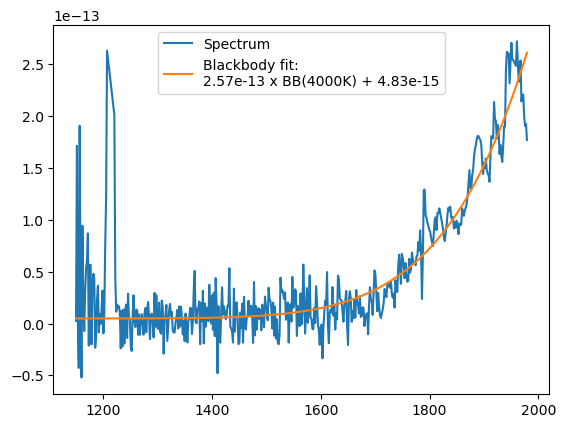

In [126]:
## Scale BB curve 

Teff = 4000.

## Mask most features to let curve_fit see the underlying emission

med = np.median(rawflux)
std = np.std(rawflux)
mask = np.logical_and((rawflux <= med + 2*std), (rawflux >= med - 2*std))

x = wavelengths[mask]
y = rawflux[mask]
yerr = fluxerr[mask]

## Fit blackbody curve to masked stellar spectrum

popt, pcov = curve_fit(lambda x, a, b: fitBB(x, Teff, a, b), x, y, 
                       sigma=yerr, 
                       bounds=((-np.inf, 0), (np.inf, np.inf))) 

BB_continuum = fitBB(wavelengths, Teff, popt[0], popt[1])
# BB_continuum[BB_continuum <= 0] = 0.


## Plot masked spectrum and scaled blackbody curve

plt.plot(x, y, label='Spectrum')
plt.plot(wavelengths, BB_continuum, label=f'Blackbody fit:\n{popt[0]:0.2e} x BB({Teff:0.0f}K) + {popt[1]:0.2e}')
plt.legend()

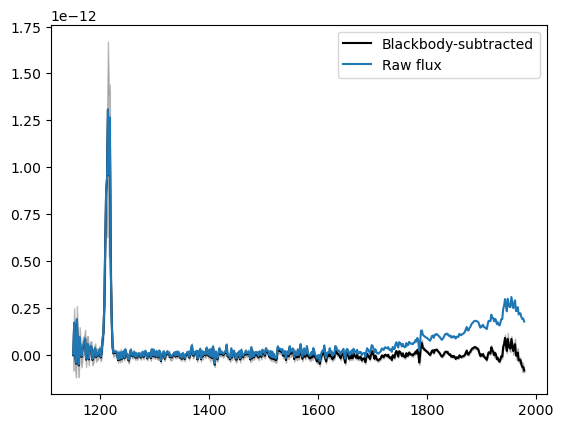

In [127]:
## Subtract BB curve

flux = rawflux - BB_continuum

## Plot BB-subtracted flux

plt.plot( wavelengths, flux, color='k', label='Blackbody-subtracted' )
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.plot( wavelengths, rawflux, label='Raw flux' )
plt.legend()

1.8343669495841453e-15 6.019797087566427e-15
1.260288463758412e-15 1.3170457698616703e-14


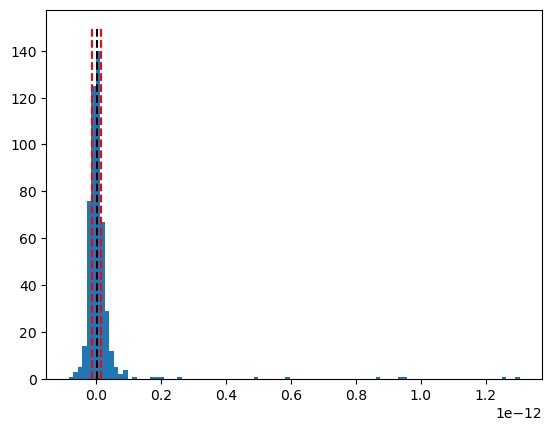

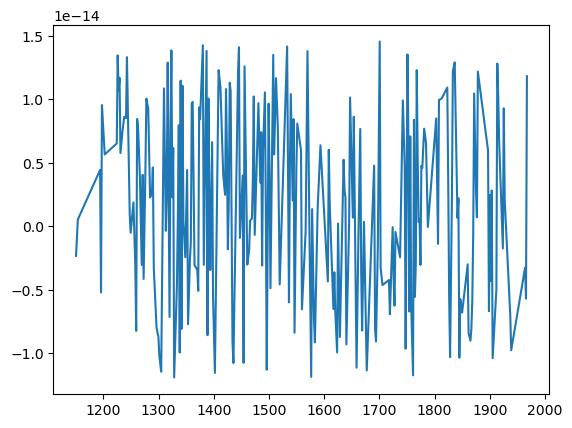

In [181]:
plt.hist(flux.value, bins=100);
# plt.xscale('log')

plt.vlines( np.median(flux).value, 0, 150, ls='--', color='k' )
plt.vlines( np.median(flux).value + MAD(flux), 0, 150, ls='--', color='r' )
plt.vlines( np.median(flux).value - MAD(flux), 0, 150, ls='--', color='r' )

noisefilter = (flux <= np.median(flux).value + MAD(flux.value)) & (flux >= np.median(flux).value - MAD(flux.value))
noise_x = wavelengths[noisefilter]
noise_y = flux[noisefilter]

print( np.median(noise_y), np.median(np.abs(noise_y)) )
print( np.median(flux), np.median(np.abs(flux)) )


plt.figure()
plt.plot(noise_x, noise_y)

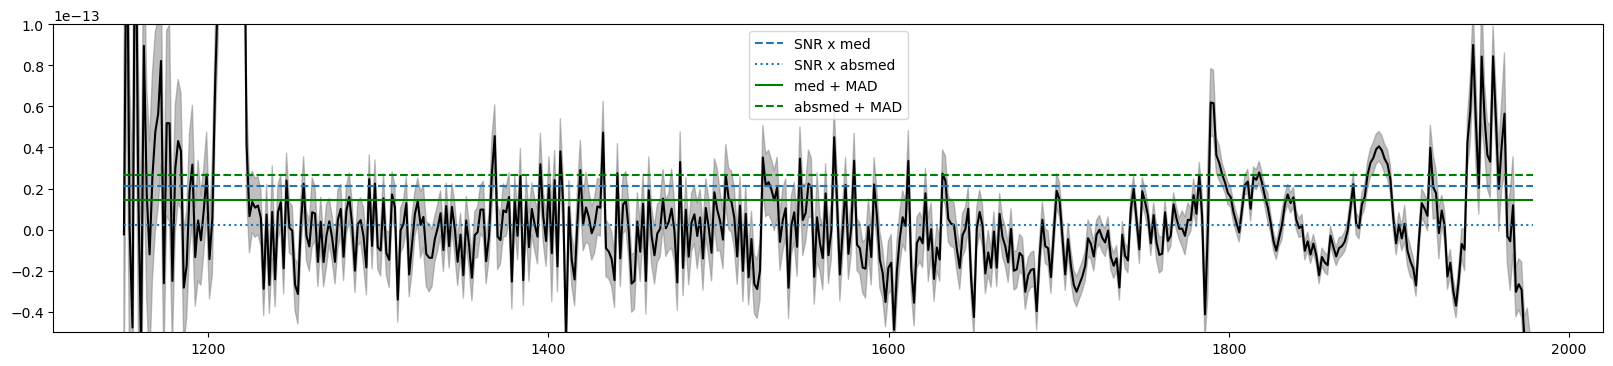

In [192]:
plt.figure(figsize=(20,4))
plt.plot( wavelengths, flux, c='k')
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.hlines( snr*np.median(np.abs(flux)), wavelengths.min(), wavelengths.max(), ls='--', label='SNR x med' )
plt.hlines( snr*np.median(flux), wavelengths.min(), wavelengths.max(), ls=':', label='SNR x absmed' )
plt.hlines( np.median(flux).value + MAD(flux), wavelengths.min(), wavelengths.max(), color='green', label='med + MAD' )
plt.hlines( np.median(np.abs(flux)).value + MAD(flux), wavelengths.min(), wavelengths.max(), color='green', ls='--', label='absmed + MAD' )

plt.ylim(-.05*10**-12, .1*10**-12)
plt.legend()

In [184]:
noisefilter

array([ True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True,  True, False, False,  True,  True, False, False,  True,
       False,  True,  True,  True,  True, False,  True, False,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False,  True, False, False,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True, False,

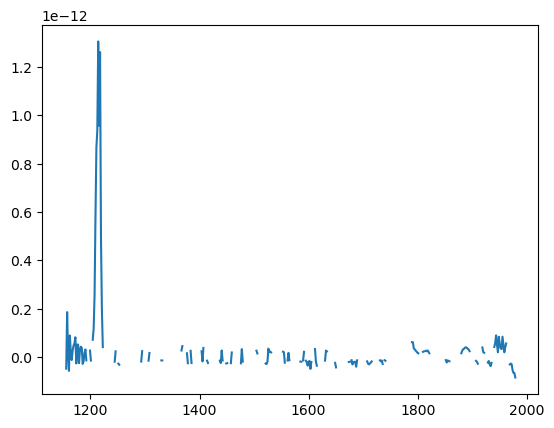

In [185]:
mask = np.array([False]*len(flux))
mask[noisefilter] = True

testarr = np.ma.array(data=flux.value, mask=mask)

# plt.plot( wavelengths[~noisefilter], flux[~noisefilter])
plt.plot( wavelengths, testarr)

In [172]:
def MAD(array):
    med = np.median(array)
    return np.median([abs(num - med) for num in array])

In [175]:
# print( np.var(noise_y), np.var(flux) )

print( MAD(noise_y), MAD(flux), np.std(flux) )

5.532633e-15 1.3301844e-14 1.1646497026333857e-13


# Identify lines

Flux threshold: 1.890432695637618e-14


line_center,line_type,line_center_index
Angstrom,,
float32,str10,int64
1170.744384765625,emission,12
1182.479248046875,emission,19
1214.3310546875,emission,38
1246.1827392578125,emission,57
1294.7984619140625,emission,86
1366.8841552734375,emission,129
1407.1177978515625,emission,153
1504.349365234375,emission,211


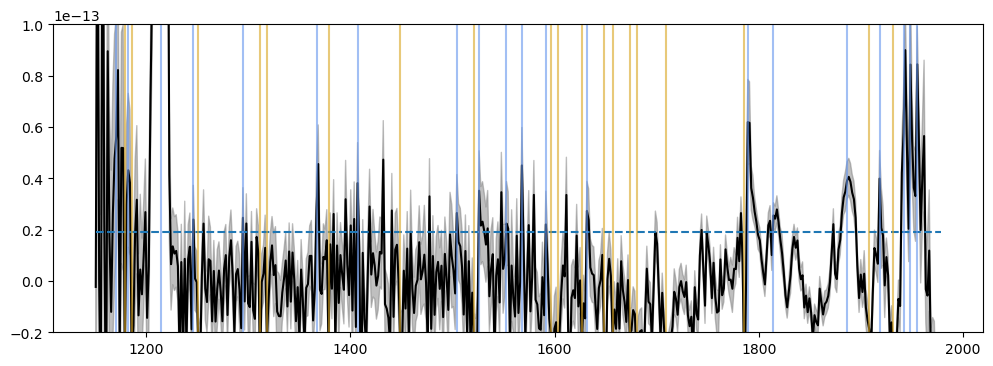

In [134]:
## Create a Spectrum1D object
spectrum = Spectrum1D(flux = flux * (u.erg/u.cm**2/u.s/u.AA), spectral_axis = wavelengths * u.AA)


## Define the uncertainty of the spectrum using everything redward of the H line FIXME
noise_region = SpectralRegion(np.floor(wavelengths[0])*u.AA, 
                              np.ceil(wavelengths[-1])*u.AA)

spectrum = noise_region_uncertainty(spectrum, noise_region)


## Find lines using a noise threshold

with warnings.catch_warnings():  # Ignore warnings

    warnings.simplefilter('ignore')

#     lines = find_lines_threshold(spectrum, noise_factor=3) 
    thresh = 15*np.median(flux).value
    lines = find_lines_derivative(spectrum, flux_threshold=thresh) # (u.erg/u.cm**2/u.s/u.AA)
    print( 'Flux threshold:', thresh )
    
display(lines)



## Plot identified lines

plt.figure(figsize=(12,4))
plt.plot( wavelengths, flux, c='k')
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')
plt.hlines( thresh, wavelengths.min(), wavelengths.max(), ls='--' )
plt.ylim(-2*10**-14, 10**-13)

for l in lines:
    
    if l['line_type']=='emission':
        plt.vlines(l['line_center'].value, -2*10**-14, 10**-13, alpha=0.6, color='cornflowerblue')
    elif l['line_type']=='absorption':
        plt.vlines(l['line_center'].value, -2*10**-14, 10**-13, alpha=0.6, color='goldenrod')
    


(1150.0, 1300.0)

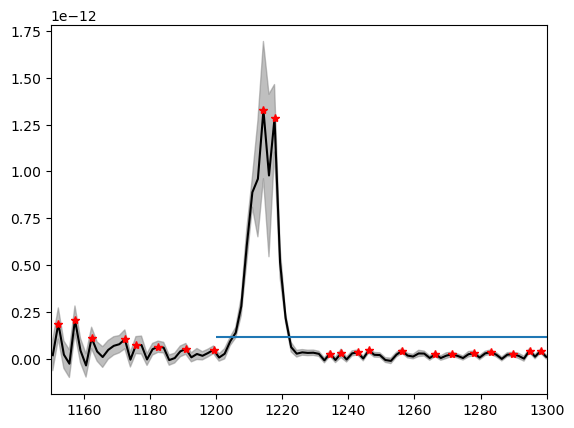

In [119]:
plt.plot( wavelengths, flux, color='k', label='Blackbody-subtracted' )
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.hlines(np.std(flux).value, 1200,2000)

plt.plot(wavelengths[peaks], flux[peaks], "*", color='red')

plt.xlim(1150,1300)

In [112]:
print( np.median(flux), np.average(flux), np.std(flux) )

8.74099715677222e-15 2.5112956487005796e-14 1.1949568125366877e-13


In [113]:
print( np.median(np.abs(flux)), np.average(np.abs(flux)), np.std(np.abs(flux)) )

1.8842297039582852e-14 3.7314369530448005e-14 1.162648400948249e-13
